# **The fifth in-class-exercise (40 points in total, 4/18/2023)**

(20 points) The purpose of the question is to practice different machine learning algorithms for text classification as well as the performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training. 

The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data. 

Algorithms:

(1) MultinominalNB

(2) SVM 

(3) KNN 

(4) Decision tree

(5) Random Forest

(6) XGBoost

(7) Word2Vec

(8) BERT

Evaluation measurement:

(1) Accuracy

(2) Recall

(3) Precison 

(4) F-1 score

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
# Creating empty lists at first to hold labels and messages
labels = []
texts = []

# Creating empty lists to contain labels and texts and performing initialization on them
with open("stsa-train.txt", "r") as file:
    for line in file:
        # Separation of the line into its label and text components
        label, text = line.split(' ', 1)
        
        # Adding the label as well as the text to the appropriate lists.
        labels.append(int(label))
        texts.append(text.strip())  # Elimination of leading and trailing whitespaces in the expression

# Constructing a DataFrame out of the lists
df = pd.DataFrame({'Label': labels, 'Text': texts})

# viewing head of dataframe
df.head()


,Label,Text
0,1,"a stirring , funny and finally transporting re..."
1,0,apparently reassembled from the cutting-room f...
2,0,they presume their audience wo n't sit still f...
3,1,this is a visually stunning rumination on love...
4,1,jonathan parker 's bartleby should have been t...


In [3]:
df.shape

(6920, 2)

In [4]:
df["Label"].unique()

array([1, 0])

In [5]:
df["Label"].value_counts()

Label
1    3610
0    3310
Name: count, dtype: int64

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


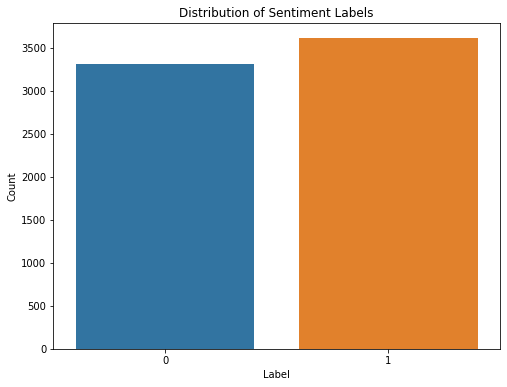

In [6]:
# Creating a count plot
plt.figure(figsize=(8, 6))
sns.countplot(x="Label", data=df)

# Adding labels and title
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Labels")
plt.show()


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   6920 non-null   int64 
 1   Text    6920 non-null   object
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [8]:
df.describe()

,Label
count,6920.000000
mean,0.521676
std,0.499566
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
#checking for columns data type
df.dtypes

Label     int64
Text     object
dtype: object

In [10]:
#checking for null values
df.isnull().sum()

Label    0
Text     0
dtype: int64

In [11]:
df.isnull().sum().sum()

0

In [12]:
import string
# Function to preprocess and clean text
def text_preprocessing(text):
    # Remove punctuation and special characters
    text = ''.join([character for character in text if character not in string.punctuation])
    
    # Remove numbers from text
    text = ''.join([character for character in text if not character.isdigit()])
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords from text
    words = [w for w in words if w.lower() not in stopwords.words('english')]
    
    # Lowercase all words
    words = [w.lower() for w in words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    
    # Joining the words back into a cleaned sentence
    cleaned_user_text = ' '.join(words)
    
    return cleaned_user_text




In [13]:
#creating new col for cleaned test
df['Cleaned_Text'] = df['Text'].apply(text_preprocessing)

In [14]:
df.head()

,Label,Text,Cleaned_Text
0,1,"a stirring , funny and finally transporting re...",stir funni final transport reimagin beauti bea...
1,0,apparently reassembled from the cutting-room f...,appar reassembl cuttingroom floor given daytim...
2,0,they presume their audience wo n't sit still f...,presum audienc wo nt sit still sociolog lesson...
3,1,this is a visually stunning rumination on love...,visual stun rumin love memori histori war art ...
4,1,jonathan parker 's bartleby should have been t...,jonathan parker bartlebi beallendal modernoffi...


In [15]:
#creating new datframe with two columns label and cleaned text
df1 = df[["Label","Cleaned_Text"]]
df1.head()

,Label,Cleaned_Text
0,1,stir funni final transport reimagin beauti bea...
1,0,appar reassembl cuttingroom floor given daytim...
2,0,presum audienc wo nt sit still sociolog lesson...
3,1,visual stun rumin love memori histori war art ...
4,1,jonathan parker bartlebi beallendal modernoffi...


In [16]:
#make into clened text into  list 
corpus = df1['Cleaned_Text'].tolist()
corpus[1:6]

['appar reassembl cuttingroom floor given daytim soap',
 'presum audienc wo nt sit still sociolog lesson howev entertainingli present trot convent sciencefict element bugey monster futurist woman skimpi cloth',
 'visual stun rumin love memori histori war art commerc',
 'jonathan parker bartlebi beallendal modernoffic anomi film',
 'campanella get tone right funni middl sad middl hope']

In [17]:
# Creating the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer

TfidfVectorizer()

In [18]:
# Transforming the text data into numerical features
X = tfidf_vectorizer.fit_transform(corpus)

# Target  column
y = df1['Label']

In [19]:
# Splitting the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Generating instances of each of the classifiers
multinominalNB_classifier = MultinomialNB()
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
decision_tree_classifier = DecisionTreeClassifier()
random_forest_classifier = RandomForestClassifier()
xgboost_classifier = XGBClassifier()

In [21]:
# Generating a dictionary of classifiers
classifiers = {
    "MultinomialNB": multinominalNB_classifier,
    "SVM": svm_classifier,
    "KNN": knn_classifier,
    "Decision Tree": decision_tree_classifier,
    "Random Forest": random_forest_classifier,
    "XGBoost": xgboost_classifier,
}


In [22]:
import numpy as np

In [23]:
# Generating a dictionary to store results
results_dictionary = {}

# Setting the CV
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# by iteratively cycling over all of the classifiers
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining & evaluating {classifier_name} model")
    
    # CV the classifier
    scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring='accuracy')
    average_accuracy = np.mean(scores)
    
    # Fitting the classifier on the X_train, y_train
    classifier.fit(X_train, y_train)
    
    # Making predictions on the validation data(X_valid)
    y_pred = classifier.predict(X_valid)
    
    # Calculating evaluation metrics on the validation data
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    # Storing the findings in the dictionary for future reference
    results_dictionary[classifier_name] = {
        'Average Accuracy (CV)': average_accuracy,
        'Accuracy (Validation data)': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }


Training & evaluating MultinomialNB model

Training & evaluating SVM model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating KNN model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating Decision Tree model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating Random Forest model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating XGBoost model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

In [24]:
results_dictionary

{'MultinomialNB': {'Average Accuracy (CV)': 0.7714984234337156,
  'Accuracy (Validation data)': 0.7926300578034682,
  'Precision': 0.7566265060240964,
  'Recall': 0.8807854137447405,
  'F1 Score': 0.8139987038237201},
 'SVM': {'Average Accuracy (CV)': 0.7722165281594975,
  'Accuracy (Validation data)': 0.8041907514450867,
  'Precision': 0.7862694300518135,
  'Recall': 0.8513323983169705,
  'F1 Score': 0.8175084175084175},
 'KNN': {'Average Accuracy (CV)': 0.5698980291289392,
  'Accuracy (Validation data)': 0.5303468208092486,
  'Precision': 0.5233853006681515,
  'Recall': 0.9887798036465638,
  'F1 Score': 0.6844660194174759},
 'Decision Tree': {'Average Accuracy (CV)': 0.6533558339480744,
  'Accuracy (Validation data)': 0.6813583815028902,
  'Precision': 0.673469387755102,
  'Recall': 0.7405329593267882,
  'F1 Score': 0.7054108216432865},
 'Random Forest': {'Average Accuracy (CV)': 0.7284930898740705,
  'Accuracy (Validation data)': 0.7507225433526011,
  'Precision': 0.7377260981912145

In [25]:
# output
for classifier_name, metrics in results_dictionary.items():
    print(f"Evaluation measurement for the {classifier_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


Evaluation measurement for the MultinomialNB:
Average Accuracy (CV): 0.7714984234337156
Accuracy (Validation data): 0.7926300578034682
Precision: 0.7566265060240964
Recall: 0.8807854137447405
F1 Score: 0.8139987038237201


Evaluation measurement for the SVM:
Average Accuracy (CV): 0.7722165281594975
Accuracy (Validation data): 0.8041907514450867
Precision: 0.7862694300518135
Recall: 0.8513323983169705
F1 Score: 0.8175084175084175


Evaluation measurement for the KNN:
Average Accuracy (CV): 0.5698980291289392
Accuracy (Validation data): 0.5303468208092486
Precision: 0.5233853006681515
Recall: 0.9887798036465638
F1 Score: 0.6844660194174759


Evaluation measurement for the Decision Tree:
Average Accuracy (CV): 0.6533558339480744
Accuracy (Validation data): 0.6813583815028902
Precision: 0.673469387755102
Recall: 0.7405329593267882
F1 Score: 0.7054108216432865


Evaluation measurement for the Random Forest:
Average Accuracy (CV): 0.7284930898740705
Accuracy (Validation data): 0.75072254335

### Predictions on Test Data

In [26]:
#Test Data
# Creating empty lists to contain labels and texts and performing initialization on them
with open("stsa-test.txt", "r") as file:
    for line in file:
        # Separation of the line into its label and text components
        label, text = line.split(' ', 1)
        
        # Adding the label as well as the text to the appropriate lists.
        labels.append(int(label))
        texts.append(text.strip())  # Elimination of leading and trailing whitespaces in the expression

# Constructing a DataFrame out of the lists
test_df = pd.DataFrame({'Label': labels, 'Text': texts})

# viewing head of dataframe
test_df.head()

,Label,Text
0,1,"a stirring , funny and finally transporting re..."
1,0,apparently reassembled from the cutting-room f...
2,0,they presume their audience wo n't sit still f...
3,1,this is a visually stunning rumination on love...
4,1,jonathan parker 's bartleby should have been t...


In [27]:
test_df.shape

(8741, 2)

In [28]:
#creating new col for cleaned test
test_df['Cleaned_Text'] = test_df['Text'].apply(text_preprocessing)

In [29]:
test_df.head()

,Label,Text,Cleaned_Text
0,1,"a stirring , funny and finally transporting re...",stir funni final transport reimagin beauti bea...
1,0,apparently reassembled from the cutting-room f...,appar reassembl cuttingroom floor given daytim...
2,0,they presume their audience wo n't sit still f...,presum audienc wo nt sit still sociolog lesson...
3,1,this is a visually stunning rumination on love...,visual stun rumin love memori histori war art ...
4,1,jonathan parker 's bartleby should have been t...,jonathan parker bartlebi beallendal modernoffi...


In [31]:
#make into clened text into  list 
corpus = test_df['Cleaned_Text'].tolist()
corpus[1:6]

['appar reassembl cuttingroom floor given daytim soap',
 'presum audienc wo nt sit still sociolog lesson howev entertainingli present trot convent sciencefict element bugey monster futurist woman skimpi cloth',
 'visual stun rumin love memori histori war art commerc',
 'jonathan parker bartlebi beallendal modernoffic anomi film',
 'campanella get tone right funni middl sad middl hope']

In [32]:
# Transforming the text data into numerical features
X_valid = tfidf_vectorizer.transform(corpus)

In [33]:
# Target  column
y_valid = test_df['Label']

In [34]:
len(y_valid)

8741

In [35]:
# Generating a dictionary to store results
results_dictionary = {}

# Setting the CV
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# by iteratively cycling over all of the classifiers
for classifier_name, classifier in classifiers.items():
    print(f"\nTraining & evaluating {classifier_name} model")
    
    # CV the classifier
    scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring='accuracy')
    average_accuracy = np.mean(scores)
    
    # Fitting the classifier on the X_train, y_train
    classifier.fit(X_train, y_train)
    
    # Making predictions on the validation data(X_valid)
    y_pred = classifier.predict(X_valid)
    
    # Calculating evaluation metrics on the validation data
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    # Storing the findings in the dictionary for future reference
    results_dictionary[classifier_name] = {
        'Average Accuracy (CV)': average_accuracy,
        'Accuracy (Validation data)': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }


Training & evaluating MultinomialNB model

Training & evaluating SVM model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating KNN model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating Decision Tree model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating Random Forest model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype


Training & evaluating XGBoost model


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

In [36]:
results_dictionary

{'MultinomialNB': {'Average Accuracy (CV)': 0.7714984234337156,
  'Accuracy (Validation data)': 0.882507722228578,
  'Precision': 0.8558907460252752,
  'Recall': 0.9291878734233238,
  'F1 Score': 0.8910344827586206},
 'SVM': {'Average Accuracy (CV)': 0.7722165281594975,
  'Accuracy (Validation data)': 0.9206040498798764,
  'Precision': 0.9117330462863293,
  'Recall': 0.9371542376631998,
  'F1 Score': 0.9242688782191182},
 'KNN': {'Average Accuracy (CV)': 0.5698980291289392,
  'Accuracy (Validation data)': 0.8217595240819128,
  'Precision': 0.7475338572145126,
  'Recall': 0.9893781810134986,
  'F1 Score': 0.8516190476190476},
 'Decision Tree': {'Average Accuracy (CV)': 0.6511822615076283,
  'Accuracy (Validation data)': 0.8736986614803798,
  'Precision': 0.8722476564203183,
  'Recall': 0.8853728701040053,
  'F1 Score': 0.878761256314518},
 'Random Forest': {'Average Accuracy (CV)': 0.7330096421879998,
  'Accuracy (Validation data)': 0.9083628875414712,
  'Precision': 0.8994413407821229,

In [37]:
# output
for classifier_name, metrics in results_dictionary.items():
    print(f"Evaluation measurement for the {classifier_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


Evaluation measurement for the MultinomialNB:
Average Accuracy (CV): 0.7714984234337156
Accuracy (Validation data): 0.882507722228578
Precision: 0.8558907460252752
Recall: 0.9291878734233238
F1 Score: 0.8910344827586206


Evaluation measurement for the SVM:
Average Accuracy (CV): 0.7722165281594975
Accuracy (Validation data): 0.9206040498798764
Precision: 0.9117330462863293
Recall: 0.9371542376631998
F1 Score: 0.9242688782191182


Evaluation measurement for the KNN:
Average Accuracy (CV): 0.5698980291289392
Accuracy (Validation data): 0.8217595240819128
Precision: 0.7475338572145126
Recall: 0.9893781810134986
F1 Score: 0.8516190476190476


Evaluation measurement for the Decision Tree:
Average Accuracy (CV): 0.6511822615076283
Accuracy (Validation data): 0.8736986614803798
Precision: 0.8722476564203183
Recall: 0.8853728701040053
F1 Score: 0.878761256314518


Evaluation measurement for the Random Forest:
Average Accuracy (CV): 0.7330096421879998
Accuracy (Validation data): 0.908362887541

## Word2Vec

In [67]:
from gensim.models import Word2Vec

In [68]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold

In [69]:
# Putting the Word2Vec model through its training.
word2vec_model = Word2Vec(sentences=[t.split() for t in df1['Cleaned_Text']], vector_size=100, window=5, min_count=1, workers=4)


In [70]:
#Word2Vec is used to convert textual data into numerical characteristics.
X_train_word2vec = np.array([np.mean([word2vec_model.wv[w] for w in text.split() if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for t in X_train])
X_valid_word2vec = np.array([np.mean([word2vec_model.wv[w] for w in text.split() if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for t in X_valid])


In [71]:
#A simple neural network classifier will now be initialised and trained.
neural_network_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
neural_network_classifier.fit(X_train_word2vec, y_train)


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MLPClassifier(max_iter=300, random_state=42)

In [72]:
# Evaluating the classifier on the validation data
y_pred_neural_network = neural_network_classifier.predict(X_valid_word2vec)

In [73]:
# Printing the  evaluation metrics
accuracy_neural_network = accuracy_score(y_valid, y_pred_neural_network)
precision_neural_network = precision_score(y_valid, y_pred_neural_network)
recall_neural_network = recall_score(y_valid, y_pred_neural_network)
f1_neural_network = f1_score(y_valid, y_pred_neural_network)

print(f"Word2Vec Neural Network Evaluation Metrics:")
print(f"Accuracy: {accuracy_neural_network}")
print(f"Precision: {precision_neural_network}")
print(f"Recall: {recall_neural_network}")
print(f"F1 Score: {f1_neural_network}")


Word2Vec Neural Network Evaluation Metrics:
Accuracy: 0.516988902871525
Precision: 0.516988902871525
Recall: 1.0
F1 Score: 0.6815987933634992


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

### Predictions test data

In [74]:
test_df.head(2)

,Label,Text,Cleaned_Text
0,1,"a stirring , funny and finally transporting re...",stir funni final transport reimagin beauti bea...
1,0,apparently reassembled from the cutting-room f...,appar reassembl cuttingroom floor given daytim...


In [75]:
len(test_df)

8741

In [76]:
test_df.shape

(8741, 3)

In [77]:
# Putting the Word2Vec model through its training.
word2vec_model_1 = Word2Vec(sentences=[t.split() for t in test_df['Cleaned_Text']], vector_size=100, window=5, min_count=1, workers=4)

In [78]:
X_test_word2vec = np.array([np.mean([word2vec_model_1.wv[w] for w in text.split() if w in word2vec_model_1.wv] or [np.zeros(100)], axis=0) for t in X_valid])

In [79]:
# Evaluating the classifier on the validation data
y_pred_neural_network = neural_network_classifier.predict(X_test_word2vec)

In [80]:
# Target  column
y_valid = test_df['Label']
# Printing the  evaluation metrics
accuracy_neural_network = accuracy_score(y_valid, y_pred_neural_network)
precision_neural_network = precision_score(y_valid, y_pred_neural_network)
recall_neural_network = recall_score(y_valid, y_pred_neural_network)
f1_neural_network = f1_score(y_valid, y_pred_neural_network)

print(f"Word2Vec Neural Network Evaluation Metrics:")
print(f"Accuracy: {accuracy_neural_network}")
print(f"Precision: {precision_neural_network}")
print(f"Recall: {recall_neural_network}")
print(f"F1 Score: {f1_neural_network}")


Word2Vec Neural Network Evaluation Metrics:
Accuracy: 0.516988902871525
Precision: 0.516988902871525
Recall: 1.0
F1 Score: 0.6815987933634992


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

## BERT

In [159]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, random_split
from keras.preprocessing.sequence import pad_sequences
import torch.nn.functional as F
import torch

In [160]:
#Bert Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# the max sequence length
max_length = 128  

# Tokenizing & encoding the text data for training the bert modl
X_train_tokens = df1['Cleaned_Text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_length, dtype="long", value=0, truncating="post", padding="post")
X_train_tokens = torch.tensor(X_train_tokens)
y_train = torch.tensor(df1['Label'].values)

# Creating a DataLoader for training the bert model
train_data = TensorDataset(X_train_tokens, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Setting up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training model
num_epochs = 3  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, labels=labels)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}")

# Saving the model
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/3, Average Loss: 0.7049385888747199
Epoch 2/3, Average Loss: 0.7016493230713983
Epoch 3/3, Average Loss: 0.700473235606046


('fine_tuned_bert_model/tokenizer_config.json',
 'fine_tuned_bert_model/special_tokens_map.json',
 'fine_tuned_bert_model/vocab.txt',
 'fine_tuned_bert_model/added_tokens.json')

In [161]:
#on Test dataset
X_valid_tokens = test_df['Cleaned_Text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
X_valid_tokens = df1['Cleaned_Text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
X_valid_tokens = pad_sequences(X_valid_tokens, maxlen=max_length, dtype="long", value=0, truncating="post", padding="post")
X_valid_tokens = torch.tensor(X_valid_tokens)
y_valid = = torch.tensor(test_df['Label'].values)

# model evaluation on test data
model.eval()
# predictions
with torch.no_grad():
    outputs = model(X_valid_tokens)
    predictions = torch.argmax(outputs.logits, dim=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_valid.cpu().numpy(), predictions.cpu().numpy())
precision = precision_score(y_valid.cpu().numpy(), predictions.cpu().numpy())
recall = recall_score(y_valid.cpu().numpy(), predictions.cpu().numpy())
f1 = f1_score(y_valid.cpu().numpy(), predictions.cpu().numpy())

print(f"Bert Evaluation Metrics:")
print("\n")
print(f"Accuracy of the Bert: {accuracy:.4f}")
print("\n")
print(f"Precision of the Bert: {precision:.4f}")
print(f"Recall of the Bert: {recall:.4f}")
print("\n")
print(f"F1 Score of the Bert: {f1:.4f}")
print("\n")


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Bert Evaluation Metrics:


Accuracy of the Bert: 0.5325


Precision of the Bert: 0.5325


Recall of the Bert: 1.0


F1 Score of the Bert: 0.6949429037520392


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

(20 points) The purpose of the question is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K-means

DBSCAN

Hierarchical clustering

Word2Vec

BERT

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 

In [162]:
#Write your code here.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

df2 = pd.read_csv("John Wick_Chapter 4_reviews.csv")
df2.head()

,Reviews
0,Imagine a video game where you are shooting ba...
1,"The Table, the international crminal brotherho..."
2,The first three John Wick films came in fairly...
3,These John Wick movies can be sort of fun in t...
4,I went to the cinema with great expectations. ...


In [163]:
df2.shape

(1250, 1)

In [164]:
df2.isnull().sum()

Reviews    0
dtype: int64

In [165]:
df2["Reviews"].dropna(inplace=True)

In [166]:
df2["Reviews"].shape

(1250,)

In [167]:
df2["Reviews"]

0       Imagine a video game where you are shooting ba...
1       The Table, the international crminal brotherho...
2       The first three John Wick films came in fairly...
3       These John Wick movies can be sort of fun in t...
4       I went to the cinema with great expectations. ...
                              ...                        
1245    HORRIBLE movie. I love John Wick. I mean I wou...
1246    In a world where movie sequels seem to be loat...
1247    May or may not count as a spoiler but John Wic...
1248    Indiana jones, terminator, predator, Jurassic ...
1249    John Wick: Chapter 4 is almost three hours of ...
Name: Reviews, Length: 1250, dtype: object

In [168]:
# Function to preprocess and clean review
def review_preprocessing(review):
    # Remove punctuation and special characters
    review = ''.join([character for character in review if character not in string.punctuation])
    
    # Remove numbers
    review = ''.join([character for character in review if not character.isdigit()])
    
    # Tokenize the review
    words = nltk.word_tokenize(review)
    
    # Remove stopwords
    words = [w for w in words if w.lower() not in stopwords.words('english')]
    
    # Lowercase all words
    words = [w.lower() for w in words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    
    # Join the words back into a cleaned sentence
    cleaned_user_reviews = ' '.join(words)
    
    return cleaned_user_reviews




In [170]:
df2['Cleaned_Reviews'] = df2['Reviews'].apply(review_preprocessing)

In [171]:
df2['Cleaned_Reviews'] 

0       imagin video game shoot bad guy hardwar old ev...
1       tabl intern crminal brotherhood condemn john w...
2       first three john wick film came fairli quick s...
3       john wick movi sort fun sen unintellig violent...
4       went cinema great expect admit photographi gor...
                              ...                        
1245    horribl movi love john wick mean wouldnt pay s...
1246    world movi sequel seem loath even relea john w...
1247    may may count spoiler john wick pill bodi coun...
1248    indiana jone termin predat jurass park matrix ...
1249    john wick chapter almost three hour keanu reev...
Name: Cleaned_Reviews, Length: 1250, dtype: object

In [172]:
# Vectorize the text using TfidfVectorizer
vectorizing = TfidfVectorizer(stop_words='english', max_features=5000)
rev_vector = vectorizing.fit_transform(df2['Cleaned_Reviews'])

In [173]:
# Standardize the vectorized features
scaler = StandardScaler()
scaled_rev = scaler.fit_transform(rev_vector.toarray())


In [174]:
# Applying the K-means clustering
k_means = KMeans(n_clusters=3, random_state=42)
df2['KMeans_Clusters'] = k_means.fit_predict(scaled_rev)
df2

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Reviews,Cleaned_Reviews,KMeans_Clusters
0,imagin video game shoot bad guy hardwar old ev...,imagin video game shoot bad guy hardwar old ev...,0
1,tabl intern crminal brotherhood condemn john w...,tabl intern crminal brotherhood condemn john w...,0
2,first three john wick film came fairli quick s...,first three john wick film came fairli quick s...,0
3,john wick movi sort fun sen unintellig violent...,john wick movi sort fun sen unintellig violent...,0
4,went cinema great expect admit photographi gor...,went cinema great expect admit photographi gor...,0
...,...,...,...
1245,horribl movi love john wick mean wouldnt pay s...,horribl movi love john wick mean wouldnt pay s...,0
1246,world movi sequel seem loath even releas john ...,world movi sequel seem loath even relea john w...,0
1247,may may count spoiler john wick pill bodi coun...,may may count spoiler john wick pill bodi coun...,0
1248,indiana jone termin predat jurass park matrix ...,indiana jone termin predat jurass park matrix ...,0


In [175]:
df2["KMeans_Clusters"].unique()

array([0, 1, 2], dtype=int32)

In [176]:
# Applying the DBSCAN clustering
dbscan_clustering = DBSCAN(eps=0.5, min_samples=5)
df2['DBSCAN_Clusters'] = dbscan_clustering.fit_predict(scaled_rev)


In [177]:
df2["DBSCAN_Clusters"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [178]:
# Apply Hierarchical clustering
hierarchical_clustering= AgglomerativeClustering(n_clusters=3)
df2['Hierarchical_Clusters'] = hierarchical_clustering.fit_predict(scaled_rev)


In [179]:
df2['Hierarchical_Clusters'].unique()

array([0, 2, 1])

In [180]:
df2.head()

,Reviews,Cleaned_Reviews,KMeans_Clusters,DBSCAN_Clusters,Hierarchical_Clusters
0,imagin video game shoot bad guy hardwar old ev...,imagin video game shoot bad guy hardwar old ev...,0,0,0
1,tabl intern crminal brotherhood condemn john w...,tabl intern crminal brotherhood condemn john w...,0,1,0
2,first three john wick film came fairli quick s...,first three john wick film came fairli quick s...,0,2,0
3,john wick movi sort fun sen unintellig violent...,john wick movi sort fun sen unintellig violent...,0,3,0
4,went cinema great expect admit photographi gor...,went cinema great expect admit photographi gor...,0,4,0


In [181]:
df2.columns

Index(['Reviews', 'Cleaned_Reviews', 'KMeans_Clusters', 'DBSCAN_Clusters',
       'Hierarchical_Clusters'],
      dtype='object')

In [182]:
df3 = df2.drop(['Reviews', 'Cleaned_Reviews'], axis=1)


In [183]:
df3.head()

,KMeans_Clusters,DBSCAN_Clusters,Hierarchical_Clusters
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

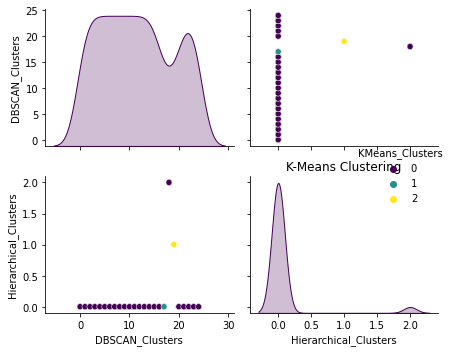

In [184]:
# Visualize the clusters
sns.pairplot(df3, hue='KMeans_Clusters', palette='viridis', diag_kind='kde')
plt.title('K-Means Clustering')
plt.tight_layout()
plt.show()

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

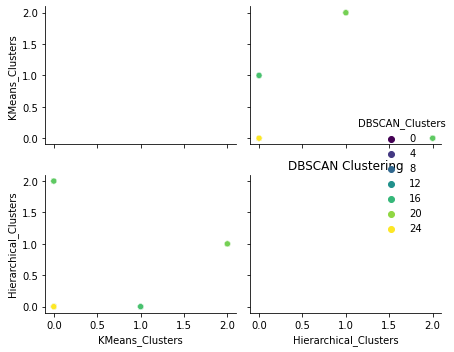

In [185]:
sns.pairplot(df3, hue='DBSCAN_Clusters', palette='viridis', diag_kind='kde')
plt.title('DBSCAN Clustering')
plt.tight_layout()
plt.show()

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

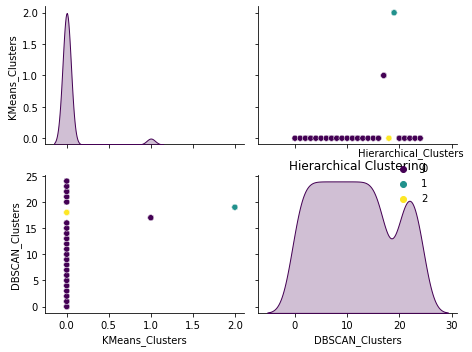

In [186]:
sns.pairplot(df3, hue='Hierarchical_Clusters', palette='viridis', diag_kind='kde')
plt.title('Hierarchical Clustering')
plt.tight_layout()
plt.show()


In [187]:
# Evaluating the  Silhouette Score for Kmaens,DBSCAN, Hierarchical clustering, 

from sklearn.metrics import silhouette_score


silhouette_kmeans_clustering = silhouette_score(scaled_rev, df3['KMeans_Clusters'])
print(f"Silhouette Score for the K-means Clustering: {silhouette_kmeans_clustering}")
print("\n")

silhouette_dbscan_clustering = silhouette_score(scaled_rev, df3['DBSCAN_Clusters'])
print(f"Silhouette Score for the DBSCAN Clustering: {silhouette_dbscan_clustering}")
print("\n")

silhouette_hierarchical_clustering = silhouette_score(scaled_rev, df3['Hierarchical_Clusters'])
print(f"Silhouette Score for the Hierarchical Clustering: {silhouette_hierarchical_clustering}")
print("\n")

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

Silhouette Score for the K-means Clustering: 0.2499598372199226


Silhouette Score for the DBSCAN Clustering: 0.9999999573711715


Silhouette Score for the Hierarchical Clustering: 0.3126512179698091




/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Word2Vec Clustering

In [188]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [189]:
# Tokenize the cleaned reviews into words
tokenized_rev = df2['Cleaned_Reviews'].apply(lambda x: x.split())
tokenized_rev

0       [imagin, video, game, shoot, bad, guy, hardwar...
1       [tabl, intern, crminal, brotherhood, condemn, ...
2       [first, three, john, wick, film, came, fairli,...
3       [john, wick, movi, sort, fun, sen, unintellig,...
4       [went, cinema, great, expect, admit, photograp...
                              ...                        
1245    [horribl, movi, love, john, wick, mean, wouldn...
1246    [world, movi, sequel, seem, loath, even, relea...
1247    [may, may, count, spoiler, john, wick, pill, b...
1248    [indiana, jone, termin, predat, jurass, park, ...
1249    [john, wick, chapter, almost, three, hour, kea...
Name: Cleaned_Reviews, Length: 1250, dtype: object

In [190]:
# Training the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_rev, vector_size=100, window=5, min_count=1, workers=4)
# Get word vectors
word_vectors = word2vec_model.wv

In [191]:
# Clustering the word vectors using KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(word_vectors.vectors)


/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [192]:
clusters

array([1, 2, 1, ..., 4, 4, 0], dtype=int32)

In [193]:
# Dimensionality reduction for the purpose of visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors.vectors)

In [194]:
pca_result

array([[-1.3035321 ,  0.9285549 ],
       [-2.547869  ,  0.94354373],
       [-2.5179193 ,  1.9255553 ],
       ...,
       [ 0.16516754,  0.6605216 ],
       [ 0.12059239,  0.8163684 ],
       [-0.80469704,  0.4470229 ]], dtype=float32)

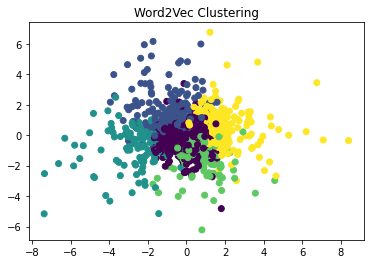

In [195]:
# Visualizing the  clusters
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.title('Word2Vec Clustering')
plt.show()


In [196]:
# Evaluating the  Silhouette Score for the Word2Vec model
from sklearn.metrics import silhouette_score
silhouette_average = silhouette_score(word_vectors.vectors, clusters)
print(f"Silhouette Score for the Word2Vec model : {silhouette_average}")

Silhouette Score for the Word2Vec model : 0.030724341049790382


### BERT Clustering

In [197]:
from transformers import BertTokenizer, BertModel
import torch

/Users/shyamsonu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


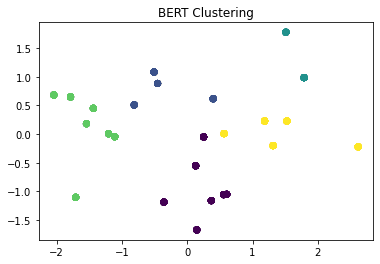

In [202]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenization and Embedding
tok_rev_bert = df2['Cleaned_Reviews'].apply(lambda x: tokenizer(x, return_tensors='pt', truncation=True, padding=True))
bert_embed = tok_rev_bert.apply(lambda x: model(**x).last_hidden_state.mean(dim=1).detach().numpy())

# Convert BERT embeddings to a matrix
bert_mat = np.array(bert_embed.tolist())

# Reshape the matrix if necessary
num_seq, seq_len, embedding_size = bert_mat.shape
reshape_bert_mat = bert_mat.reshape(num_seq, seq_len, embedding_size)

# Reshape the matrix by flattening the sequence dimension
flatten_bert_mat = bert_mat.reshape(-1, embedding_size)

# PCA for BERT embeddings
pca_bert = PCA(n_components=2)
pca_result_bert = pca_bert.fit_transform(flatten_bert_mat)

# KMeans clustering for BERT PCA embeddings
kmeans_bert = KMeans(n_clusters=5, random_state=42)
clusters_bert = kmeans_bert.fit_predict(pca_result_bert)

# Visualize BERT clusters
plt.scatter(pca_result_bert[:, 0], pca_result_bert[:, 1], c=clusters_bert, cmap='viridis')
plt.title('BERT Clustering')
plt.show()

In [204]:
# Evaluating the  Silhouette Score for the BERT Clustering model
silhouette_avg_bert = silhouette_score(flatten_bert_mat, clusters_bert)

print(f"Silhouette Score for the BERT Clustering model: {silhouette_avg_bert:.3f}")

Silhouette Score for the BERT Clustering model: 0.230


In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

In [ ]:
#You can write you answer here. (No code needed)

Silhouette Score for the K-means Clustering: 0.2499598372199226

Silhouette Score for the DBSCAN Clustering: 0.9999999573711715

Silhouette Score for the Hierarchical Clustering: 0.3126512179698091
    
Silhouette Score for the Word2Vec model : 0.030724341049790382
        
Silhouette Score for the BERT Clustering model: 0.230

The analysis of the results produced by the several clustering algorithms reveals that their individual performance metrics are distinct from one another. The Silhouette Scores are essential indicators of the quality of the grouping. The K-means method has a score of 0.25, which is regarded to be moderate and suggests that there are identifiable but not particularly well-defined clusters. In other words, the score shows that there exist clusters. In stark contrast to this, DBSCAN gets an amazing Silhouette Score of 1, which indicates the generation of dense clusters that can be readily distinguished from one another. The hierarchical clustering technique earns a score of 0.31, which suggests that the clusters it creates are generally well-formed. This can be seen by the fact that the hierarchical clustering method receives this score. The Word2Vec model, which was developed exclusively for analysing textual data, has a very low Silhouette Score of 0.03, which is indicative of a smaller number of recognisable clusters in the data. The BERT Clustering model, on the other hand, which takes use of contextual embeddings, obtains a score of 0.23, which shows a degree of separation between clusters that is deemed to be of a moderate nature. While the Hierarchical and BERT models both show impressive performance in producing relatively different clusters, DBSCAN excels in the formation of dense, well-defined clusters. The choice of clustering algorithms and embedding models has a substantial impact, in essence, on the quality of the cluster that is produced as a consequence of their use.

# Thank you